## Analysis
- Seasons of interest - June, July, August, September.
- Districts of interest - Kolhapur, Latur

- A new LSTM model to predict rainfall.

### Import libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_json

from importlib import reload
import itertools

### Useful functions

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

### Dataset

In [5]:
PATH = 'Dataset/rainfall_data_1901_to_2002.xlsx'
data = pd.read_excel(PATH)

### Preprocess data

In [6]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))

m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')

districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [7]:
m_data = maharashtra_data.copy()

In [8]:
m_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


### Useful functions

In [9]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [10]:
def get_latest_file(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [11]:
def LSTM_model(num_of_previous_months, hidden_nodes_months, 
               num_of_previous_years, hidden_nodes_years, output_nodes=1):
    
    visible1 = Input((num_of_previous_months, 1))
#     visible1 = Input((1, num_of_previous_months))
    extract1 = LSTM(hidden_nodes_months, activation='relu')(visible1)

    visible2 = Input((num_of_previous_years, 1))
#     visible2 = Input((1, num_of_previous_years))
    extract2 = LSTM(hidden_nodes_years, activation='relu')(visible2)

    merge = concatenate([extract1, extract2])
    output = Dense(output_nodes)(merge)
    
    model = Model(inputs = [visible1, visible2], outputs = output)
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    return model

In [12]:
def preprocess_data(m_data, district, month, num_of_previous_months, num_of_previous_years, future_steps):
    
#     rainfall_season_data = m_data[['Date', 'Year', 'Month'] + districts_of_interest]
    rainfall_data = m_data[['Date', 'Year', 'Month', district]]
    month_data = rainfall_data[rainfall_data.Month == month]
    
    start_year = int(rainfall_data.Year.min())
    last_year = int(rainfall_data.Year.max())
    current_year = start_year + num_of_previous_years
    month_data_index = month_data.index
    
    train_data_input_1 = []
    for index in month_data_index[num_of_previous_years:]:
        data = list(rainfall_data.iloc[index - num_of_previous_months:index][district])
        train_data_input_1.append(data)
    train_data_input_1 = np.array(train_data_input_1)
    shape = train_data_input_1.shape
    train_data_input_1 = train_data_input_1.reshape(shape[0], shape[1], 1)
    
    month_data_prep = list(month_data[district])
    train_data_input_2 = []
    for i in range(0, len(month_data_prep) - num_of_previous_years):
        data = month_data_prep[i:i+num_of_previous_years]
        train_data_input_2.append(data)
    train_data_input_2 = np.array(train_data_input_2)
    shape = train_data_input_2.shape
    train_data_input_2 = train_data_input_2.reshape(shape[0], shape[1], 1)
    
    y_train = list(month_data.iloc[num_of_previous_years:][district])
    y_train = np.array(y_train)
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    
    date_index = list(month_data.iloc[-1*future_steps:]['Date'])
        
    return train_data_input_1, train_data_input_2, y_train, date_index

In [13]:
def split_and_train_LSTM(model, input_1, input_2, y_train_main, future_steps, epochs, batch_size):
    X_train_input_1, X_test_input_1, y_train, y_test = train_test_split(input_1, y_train_main, 
                                                                    test_size=future_steps, shuffle=False, random_state=42)
    X_train_input_2, X_test_input_2, y_train, y_test = train_test_split(input_2, y_train_main, 
                                                                    test_size=future_steps, shuffle=False, random_state=42)
    
    SOURCE_PATH = 'Models/'
    checkpoint = ModelCheckpoint(SOURCE_PATH + 'model-{epoch:03d}.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
    
    model.fit([X_train_input_1, X_train_input_2], y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, validation_split=0.1, callbacks=[checkpoint])
    
    file_name = get_latest_file(SOURCE_PATH)
    model.load_weights(file_name)
    os.system('rm -rf %s/*' % SOURCE_PATH)
    
    return model, X_test_input_1, X_test_input_2, y_test

In [14]:
def predict_LSTM(model, X_test_input_1, X_test_input_2):
    y_pred = model.predict([X_test_input_1, X_test_input_2])
    return y_pred

In [15]:
def Long_Short_Term_Memory(data, district, month, num_of_prev_months, num_of_prev_years, hidden_nodes_months, hidden_nodes_years, epochs, batch_size, future_steps):
    output_nodes = 1
    model = LSTM_model(num_of_prev_months, hidden_nodes_months, num_of_prev_years, hidden_nodes_years, output_nodes)
    train_data_input_1, train_data_input_2, y_train_main, date_index = preprocess_data(m_data, district, month, num_of_prev_months, num_of_prev_years, future_steps)
    model, X_test_input_1, X_test_input_2, y_test = split_and_train_LSTM(model, train_data_input_1, train_data_input_2, y_train_main, future_steps, epochs, batch_size)
    
    y_pred = predict_LSTM(model, X_test_input_1, X_test_input_2)
    return model, y_test, y_pred, date_index

In [16]:
def find_best_method_LSTM(parameters_LSTM, m_data, district, month):
    combination_of_params = get_combinations(parameters_LSTM)
    information_LSTM = []
    iterator = 0
    
    print('LSTM - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1
        
        num_of_previous_months = param[0]
        num_of_previous_years = param[1]
        hidden_nodes_months = param[2]
        hidden_nodes_years = param[3]
        epochs = param[4]
        batch_size = param[5]
        future_steps = param[6]
        
        model_LSTM, y_test, y_pred, date_index = Long_Short_Term_Memory(m_data, district, month, num_of_previous_months, num_of_previous_years,
                  hidden_nodes_months, hidden_nodes_years, epochs, batch_size, future_steps)
        
        mse, mae, mape, rmse = calculate_performance(y_test, y_pred)
        
        y_test = list(np.reshape(y_test, (y_test.shape[0])))
        y_pred = list(np.reshape(y_pred, (y_pred.shape[0])))
        
        info = list(param) + [mse, mae, rmse, mape] + y_pred
        information_LSTM.append(info)
        
        print(y_pred)
        
    information_LSTM_df = pd.DataFrame(information_LSTM)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_LSTM_df.columns = ['Num of previous months', 'Num of previous years', 'Hidden nodes months', 
                                   'Hidden nodes years', 'epochs', 'batch_size', 'future_steps', 
                                   'MSE', 'MAE', 'RMSE', 'MAPE'] + indexes
    
    optimized_params = information_LSTM_df.iloc[information_LSTM_df.RMSE.argmin]
    future_steps = optimized_params.future_steps
    y_pred = optimized_params[-1*int(future_steps):]
    
    num_of_previous_months = int(optimized_params['Num of previous months'])
    hidden_nodes_months = int(optimized_params['Hidden nodes months'])
    num_of_previous_years = int(optimized_params['Num of previous years'])
    hidden_nodes_years = int(optimized_params['Hidden nodes years'])
    
    best_model = LSTM_model(num_of_previous_months, hidden_nodes_months, 
                   num_of_previous_years, hidden_nodes_years, output_nodes=1)
    
    return information_LSTM_df, optimized_params, y_test, y_pred, date_index, best_model

In [17]:
def save_information(OUTPUT_FOLDER, best_model, information_LSTM_df, optimized_params, y_test, y_pred, date_index, district, month):
    name = 'LSTM'
    information_LSTM_df.to_csv(OUTPUT_FOLDER + 'LSTM_information.csv', index=False)
    optimized_params.to_csv(OUTPUT_FOLDER + 'LSTM_optimized_values.csv')
    
    plot_model(best_model, OUTPUT_FOLDER + 'LSTM_best_fit_functional_model.png', show_shapes=True, show_layer_names=True)
    
    actual_forecast = pd.DataFrame({'Actual': y_test, 'Forecasted': y_pred})
    actual_forecast['Errors'] = actual_forecast['Actual'] - actual_forecast['Forecasted']
    actual_forecast.index = date_index
    actual_forecast.to_csv(OUTPUT_FOLDER + 'LSTM_actual_and_forecasted.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(actual_forecast.drop(columns=['Forecasted', 'Errors']), color='green', label='Actual values')
    plt.plot(actual_forecast.drop(columns=['Actual', 'Errors']), color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Monthly mean Precipitation')
    plt.legend(loc='best')
    plt.title(name + ' - ' + district + ' - ' + month + ' - Comaprison: Actual vs Forecasted')
    plt.savefig(OUTPUT_FOLDER + name + '_best_forecast'  + '.png')
    
    plt.figure(figsize=(10,5))
    plt.plot(actual_forecast.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.title(name + ' - ' + district + ' - ' + month + ' - Error: Actual - Forecasted')
    plt.savefig(OUTPUT_FOLDER + name + '_error_plot'  + '.png')

In [18]:
future_steps = 10

# number_of_previous_months, number_of_previous_years, hidden_nodes_months, hidden_nodes_years, epochs, batch_size, future_steps
parameters_LSTM = [[4,8,12], [4,6,8], [6,8,10], [5,7,8], [200], [10], [future_steps]]
# parameters_LSTM = [[4,8], [4], [3], [5], [1], [10], [future_steps]]

In [19]:
districts_of_interest = ['Kolhapur'] #Latur
months_of_interest = ['Aug'] #, 'Jul', 'Aug', 'Sep']

LSTM - Number of combinations: 81
1 -> [423.69757, 699.5357, 278.1963, 460.87674, 577.212, 440.88525, 496.31152, 377.15997, 254.48279, 0.23402555]
2 -> [396.17422, 648.89325, 374.0973, 450.8147, 582.1512, 416.92258, 447.21344, 366.44763, 269.6159, 129.36945]
3 -> [421.9668, 706.15094, 274.7182, 424.22116, 548.8548, 449.20535, 478.37695, 379.12766, 248.20822, 69.35319]
4 -> [425.2963, 704.94385, 274.23465, 427.82364, 552.81323, 449.55252, 472.856, 374.32025, 249.01947, 454.78568]
5 -> [401.84534, 616.1028, 155.86131, 518.9337, 673.92377, 481.21194, 575.97217, 344.01547, 228.51247, 365.1876]
6 -> [1.524215, 1.524215, 1.524215, 1.524215, 1.524215, 1.524215, 1.524215, 1.524215, 1.524215, 1.524215]
7 -> [1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366, 1.5868366]
8 -> [328.97147, 363.87616, 350.35196, 334.75403, 271.11874, 348.2169, 351.43124, 357.25168, 389.57816, 263.75974]
9 -> [371.17725, 659.2467, 250.93681, 393.3515, 551.5254, 420.2099

73 -> [410.03436, 711.45013, 192.42549, 426.77493, 388.91742, 428.7265, 490.5376, 372.58148, 240.93536, 148.63373]
74 -> [379.18427, 656.9056, 350.1388, 350.00006, 432.9873, 304.2742, 463.101, 299.5838, 237.63292, 243.67102]
75 -> [400.76068, 388.017, 383.48834, 369.83456, 348.3772, 399.8165, 393.39792, 383.05466, 316.89172, 358.65445]
76 -> [549.59357, 341.13257, 277.96222, 508.90625, 432.49255, 478.68015, 489.01117, 394.00818, 334.67648, 32.639076]
77 -> [455.07587, 765.4736, 347.34424, 411.32883, 339.30127, 488.23474, 473.18048, 357.3446, 281.7121, 167.40504]
78 -> [430.1281, 355.1228, 1013.90924, 478.96954, 385.46698, 412.1677, 389.1302, 2755.5144, 281.17456, 301.3006]
79 -> [408.8148, 366.66418, 376.54843, 318.3144, 282.4311, 456.3468, 442.30814, 327.77756, 311.27805, 291.80255]
80 -> [421.67538, 476.56558, 325.65414, 269.82364, 304.28842, 622.6173, 416.92328, 335.99915, 362.92197, 213.72588]
81
[483.02487, 369.5531, 338.32666, 310.8466, 281.39743, 736.466, 423.1962, 253.65436, 26

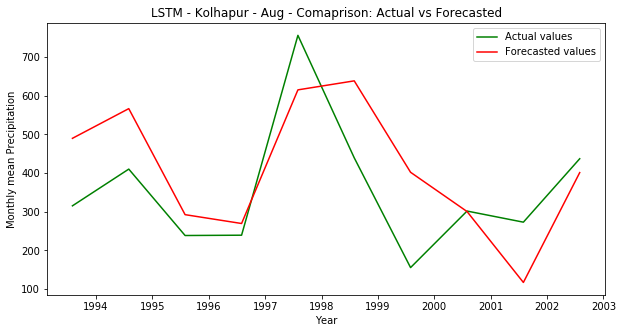

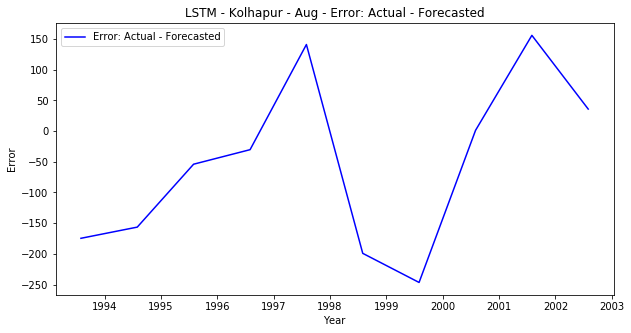

In [20]:
STORAGE_FOLDER = 'State_predictions_new_LSTM/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

for district in districts_of_interest:
    for month in months_of_interest:
        information_LSTM_df, optimized_params, y_test, y_pred, date_index, best_model = find_best_method_LSTM(parameters_LSTM, m_data, district, month)
        
        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        save_information(output_folder, best_model, information_LSTM_df, optimized_params, y_test, y_pred, date_index, district, month)